# A simple CNN for the edge lover task

**Goal:** In this notebook you train a very simple CNN with only 1 kernel to discriminate images containing vertical from those containing horizontal stripes. To check what pattern is recognized by the learned kernel you will visualize the weights of the kernel as an image. You will see that the CNN leans a useful kernel (either a vertical or horiziontal bar).You can experiment with the code to check the influence of the kernel size, the activation function and the pooling method on the result.  

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it.  

**Dataset:** You work with an artficially generatet dataset of greyscale images (50x50 pixel) with 10 vertical or horizontal bars. We want to classify them into whether or not an art lover will like them(0 or 1).  

**Content:**
* definig and generating the dataset X_train and X_val
* visualize samples of the generated images
* use keras to train a CNN with only one kernel (5x5 pixel)
* visualize the weights of the leaned kernel and interpret if it is useful
* repeat the last two steps to check if the learned kernel is always the same

Original python version 
| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_02/nb_ch02_03.ipynb)


# Installing TensorFlow and Keras

The deep learning packages, TensorFlow and Keras are not installed by default, but can be installed as follows:

In [2]:
#For Kaggle NB no extra installation is requires
if (FALSE) {
    #Colab Notebooks
    #Installing TF and Keras takes approx 2 minutes
    ptm <- proc.time()
    install.packages("tensorflow")
    install.packages("keras")
    install.packages("RCurl")
    install.packages("kableExtra")
    install.packages("reshape2")
    proc.time() - ptm
    #devtools::install_github("rstudio/keras") works ok but no tfp
}

# Imports

In the next cell, we load all the required libraries and functions. 

In [4]:
library(keras)
library(tensorflow)
tf$version$VERSION #2.6.5

[1] "2.6.5"

# Preparing the Data

### Image generator function

Here we define the function to generate images with vertical and horizontal bars, the arguments of the functions are the size of the image and the number of bars you want to have. The bars are at random positions in the image with a random length. The image is black and white, meaning we have only two values for the pixels, 0 for black and 255 for white.

In [5]:
#define function to generate image with shape (size, size, 1) with stripes
f.stripes <- function(size,bar_nr,vertical=TRUE){
  img <- matrix(0, nrow = size, ncol = size)
  for (i in 1:bar_nr){
    x <- runif(1, min = 1, max = size)
    y <- runif(1, min = 1, max = size)
    l <- runif(1, min = y, max = size)
    if (vertical){
      img[y:l,x] <- 255
    }
    else{
      img[x,y:l] <- 255
    }
  }
  return(img)
}

Let's have a look how the generated images. We choose a size of 50x50 pixels and set the nr of bars in the image to 10.


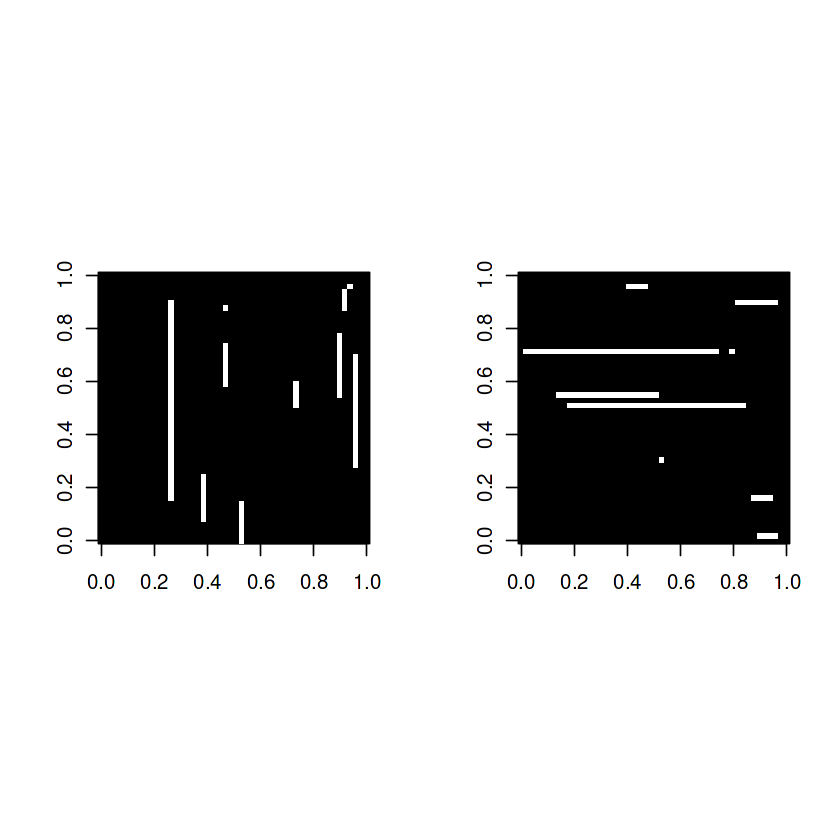

In [6]:
par(mfrow=c(1,2))
par(pty="s")
image(f.stripes(50,10,FALSE),col=c("black","white"))
image(f.stripes(50,10,TRUE),col=c("black","white"))

**Make a train and validation dataset of images with vertical and horizontal images**

Now, let's make a train dataset `X_train` with 1000 images (500 images with vertical and 500 images with horizontal bars). We normalize the images values to be between 0 and 1 by dividing all values with 255. We create a second dataste `X_val` with exactly the same properties to validate the training of the CNN.


In [7]:
pixel <- 50 # define height and width of images
num_images_train <- 1000 #Number of training examples (divisible by 2) 
num_images_val <- 1000 #Number of training examples (divisible by 2) 

# generate training data with vertical edges
X_train <- array(data = 0, dim= c(num_images_train,pixel,pixel,1))
for (i in 1:(num_images_train/2)){
  X_train[i,,,] <- f.stripes(pixel,10)
}
#... with horizontal
for (i in (num_images_train/2+1):num_images_train){
  X_train[i,,,] <- f.stripes(pixel,10,vertical = FALSE)
}

# generate validation data 
X_val <- array(data = 0, dim= c(num_images_val,pixel,pixel,1))
for (i in 1:(num_images_val/2)){
  X_val[i,,,] <- f.stripes(pixel,10)
}
#... with horizontal
for (i in (num_images_val/2+1):num_images_val){
  X_val[i,,,] <- f.stripes(pixel,10,vertical = FALSE)
}

# normalize the data to be between 0 and 1
X_train=X_train/255
X_val=X_val/255

print(dim(X_train))
print(dim(X_val))

[1] 1000   50   50    1
[1] 1000   50   50    1


Here we make the labels for the art lover, 0 means he likes the image and 1 means that he doesn't like it. We convert the labels into the one hot encoding because we want to use two outputs in our network.

In [8]:
Y_train <- cbind(c(rep(1,num_images_train/2),
                   rep(0,num_images_train/2)),
                 c(rep(0,num_images_train/2),
                   rep(1,num_images_train/2)))
Y_val <- cbind(c(rep(1,num_images_train/2),
                 rep(0,num_images_train/2)),
                 c(rep(0,num_images_train/2),
                   rep(1,num_images_train/2)))

# Defining the CNN 

Here we define a simple CNN with only one convolutional layer that we train to predict which images the art lover likes. 

For this CNN is build as follows

1. we start with a convolutional layer with only one kernel with a size of 5x5 pixels and a linar activation function
2. we use maxpooling layer with the same size as the activation map (which is very uncomon) to determine the maximum of the activation map.
4. then we use a dense layer with two nodes and a softmax activation to predict the probability that the art lover will like the image or will not like it.

As loss we use the categorical_crossentropy and we train for 20 epochs with a batchsize of 64 images per update.

### Listing 2.5 Edge lover CNN

In [9]:
model <- keras_model_sequential()
model %>%
  layer_conv_2d(filters=1,
                kernel_size = c(5,5),
                padding = 'same',
                input_shape = c(pixel,pixel,1),
                activation = 'linear') %>%
  # take the max over all values in the activation map
  layer_max_pooling_2d(pool_size = c(pixel,pixel)) %>%
  layer_flatten() %>%
  layer_dense(units = 2,activation = 'softmax')

# compile model and initialize weights
model %>%
  compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = c('accuracy')
  )


**Question** (give it a try before checking the answer below)

* how many parameters does this NN have?

In [10]:
# let's summarize the CNN architectures along with the number of model weights
summary(model)

Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d (Conv2D)                     (None, 50, 50, 1)               26          
________________________________________________________________________________
max_pooling2d (MaxPooling2D)        (None, 1, 1, 1)                 0           
________________________________________________________________________________
flatten (Flatten)                   (None, 1)                       0           
________________________________________________________________________________
dense (Dense)                       (None, 2)                       4           
Total params: 30
Trainable params: 30
Non-trainable params: 0
________________________________________________________________________________


**Answer**

5*5+1=26 for the convolution and 2+2=4 for the fully connected layer --> the NN has 30 trainable parameters

# Training of the model

In [11]:
# train the model
history <- model %>% 
  fit(x = X_train,
      y = Y_train,
      validation_data=list(X_val,Y_val),
      batch_size = 64,
      verbose = 0,
      epochs = 50,
      shuffle = TRUE)

In the next cell we plot the accuray and loss of the train and validation vs the number of train eprochs to see how the development

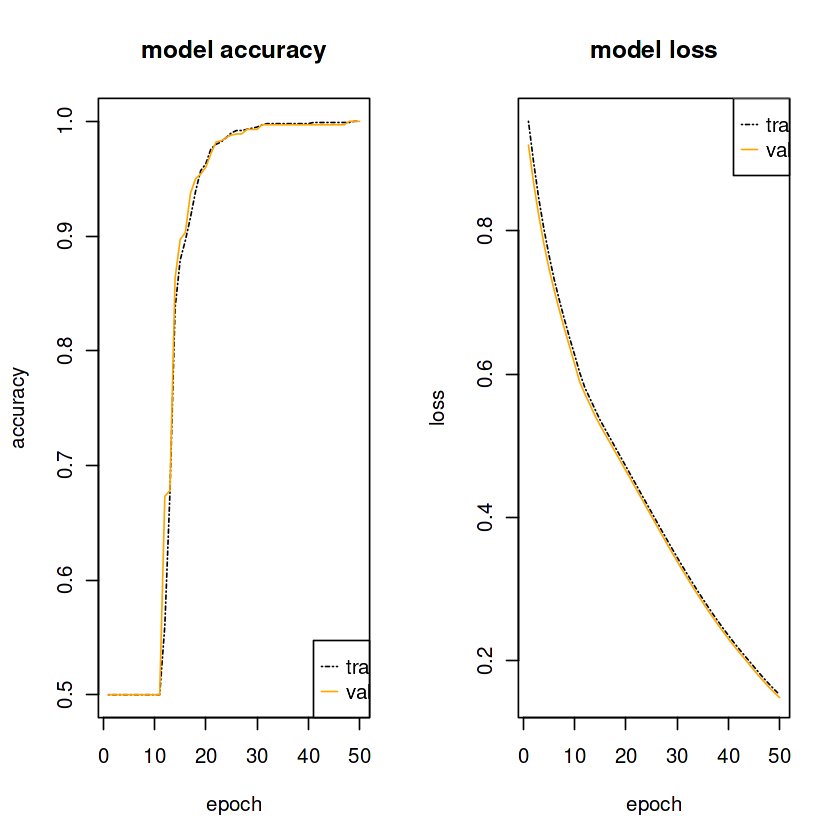

In [12]:
par(mfrow=c(1,2))
plot(history$metrics$accuracy,
     type="l",
     lty=4,
     main="model accuracy",
     ylab="accuracy",
     xlab="epoch")
lines(history$metrics$val_accuracy,
      col="orange")
legend("bottomright",legend=c("train","valid"),col=c("black","orange"),lty=c(4,1))

plot(history$metrics$loss,
     type="l",
     lty=4,
     main="model loss",
     ylab="loss",
     xlab="epoch")
lines(history$metrics$val_loss,
      col="orange")
legend("topright",legend=c("train","valid"),
       col=c("black","orange"),lty=c(4,1))

**Visualize the learned kernel and experiment with the code**

You see that the CNN performs very good at this task (100% accuracy). We can check which pattern is recognized by the learned kernel and see if you think that this is helpful to distinguish between images with horizontal and vertical edges.

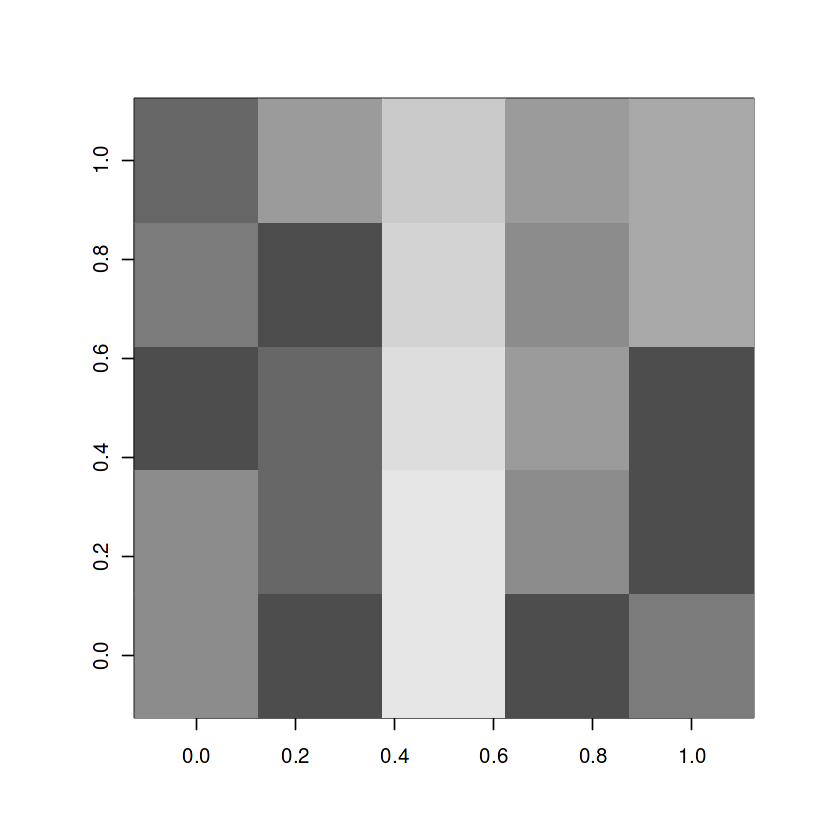

In [13]:
conv_filter = get_weights(model)[[1]]
par(pty="s")
image(conv_filter[,,,1],col = gray.colors(12))

# Additional Task

Repeat the training and experiment with different kernelsize and activation function.

<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  
*Exercise: Repeat the compiling and training for several times and check if the CNN always learns the same kernel.
You can experiment with the code and check what happens if you use another kernel size, activation function (relu instead of linear ) or pooling method AveragePooling instead of MaxPooling.
Try to make a prediction before doing the experiment*

In [14]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.4 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] tensorflow_2.9.0 keras_2.6.0      bigrquery_1.4.0  httr_1.4.4      

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.9           pillar_1.8.1         compiler_4.0.5      
 [4] dbplyr_2.2.1         base64enc_0.1-3      tools_4.0.5         
 [